In [1]:
import sys
import os
import numpy as np
from collections import OrderedDict
sys.path.append(os.pardir)
from layers import *
from gradient import numerical_gradient

class TwoLayerNet:
    def __init__(self, input_size, hidden_size, output_size,
        weight_init_std=0.01):
        # 가중치 초기화
        self.params = {}
        self.params['W1'] = 2 * np.random.randn(input_size, hidden_size) / np.sqrt(input_size)
        self.params['b1'] = np.zeros(hidden_size)
        
        self.params['W2'] = 2 * np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.params['b2'] = np.zeros(hidden_size)

        self.params['W3'] = 2 * np.random.randn(hidden_size, output_size) / np.sqrt(hidden_size)
        self.params['b3'] = np.zeros(output_size)


        # 계층 생성
        self.layers = OrderedDict()
        self.layers['Affine1'] = \
            Affine(self.params['W1'], self.params['b1'])
        #############
        self.layers['Relu1'] = Relu()
        
        self.layers['Affine2'] = \
            Affine(self.params['W2'], self.params['b2'])
        ##############
        self.layers['Relu2'] = Relu()
        
        self.layers['Affine3'] = \
            Affine(self.params['W3'], self.params['b3'])
        
        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    # x : 입력 데이터, t : 정답 레이블
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t)

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)
        if t.ndim != 1:
            t = np.argmax(t, axis=1)

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        grads['W1'] = numerical_gradient(loss_W, self.params['W1'])
        grads['b1'] = numerical_gradient(loss_W, self.params['b1'])
        grads['W2'] = numerical_gradient(loss_W, self.params['W2'])
        grads['b2'] = numerical_gradient(loss_W, self.params['b2'])
        grads['W3'] = numerical_gradient(loss_W, self.params['W3'])
        grads['b3'] = numerical_gradient(loss_W, self.params['b3'])

        return grads

    def gradient(self, x, t):
        # 순전파
        self.loss(x, t)

        # 역전파
        dout = 1
        dout = self.lastLayer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 결과 저장
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db
        grads['W3'] = self.layers['Affine3'].dW
        grads['b3'] = self.layers['Affine3'].db

        return grads

class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        if self.h is None:
            self.h = {}

            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

train acc, test acc | 0.1556, 0.1613
train acc, test acc | 0.8918833333333334, 0.8921
train acc, test acc | 0.91465, 0.9144
train acc, test acc | 0.9226166666666666, 0.9189
train acc, test acc | 0.9287166666666666, 0.9251
train acc, test acc | 0.9319666666666667, 0.9269
train acc, test acc | 0.9341333333333334, 0.9301
train acc, test acc | 0.9360666666666667, 0.9316
train acc, test acc | 0.9391166666666667, 0.9345
train acc, test acc | 0.9413833333333333, 0.9342
train acc, test acc | 0.9424, 0.935
train acc, test acc | 0.94525, 0.9378
train acc, test acc | 0.9457166666666666, 0.9395
train acc, test acc | 0.9476166666666667, 0.9393
train acc, test acc | 0.9471666666666667, 0.9398
train acc, test acc | 0.9492166666666667, 0.9424
train acc, test acc | 0.9501833333333334, 0.9422
train acc, test acc | 0.9512333333333334, 0.9441
train acc, test acc | 0.9525166666666667, 0.9428
train acc, test acc | 0.9532, 0.9447
train acc, test acc | 0.9532333333333334, 0.9454
train acc, test acc | 0.95485,

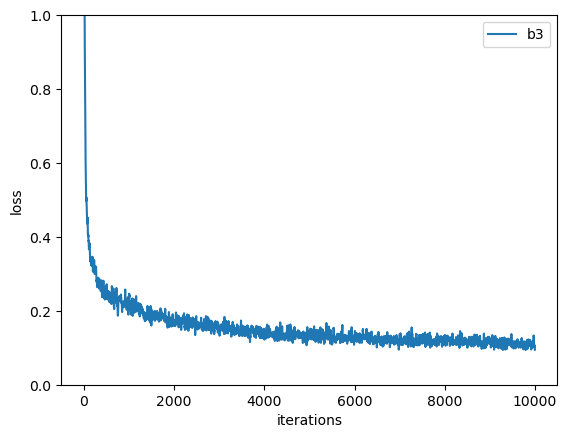

In [8]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
sys.path.append(os.pardir)
from dataset.mnist import load_mnist
from util import smooth_curve

# 데이터 읽기
(x_train, t_train), (x_test, t_test) = \
    load_mnist(normalize=True, one_hot_label=True)
network = TwoLayerNet(input_size=784, hidden_size=15, output_size=10)

# 하이퍼 파라메터
iters_num = 10000  # 반복횟수
train_size = x_train.shape[0]
batch_size = 400  # 미니배치 크기
learning_rate = 0.019

train_loss_list = []
train_acc_list = []
test_acc_list = []

# 1에폭당 반복 수
iter_per_epoch = max(train_size / batch_size, 1)

#매개변수 갱신에 필요한 h
h = None

if h is None:
    h = {}
    for key, val in network.params.items():
        h[key] = np.zeros_like(val)

for i in range(iters_num):
    # print(i)
    # 미니배치 획득
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 오차역전파법으로 기울기 계산
    grad = network.gradient(x_batch, t_batch)

    # 매개변수 갱신
    for key in ('W1', 'b1', 'W2', 'b2', 'W3', 'b3'):
        #network.params[key] -= learning_rate * grad[key]
        h[key] += grad[key] * grad[key]
        network.params[key] -= learning_rate * grad[key] / (np.sqrt(h[key]) + 1e-7)

    # 학습 경과 기록
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    # 1에폭 당 정확도 계산
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

x = np.arange(iters_num)
#train_loss_list_int = list(map(float, train_loss_list))
plt.plot(x, smooth_curve(train_loss_list), label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()